In [44]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import silhouette_score

In [45]:
df = pd.read_csv('Clustering_gmm (2).csv')

In [46]:
df.head()

,Weight,Height
0,67.062924,176.086355
1,68.804094,178.388669
2,60.930863,170.284496
3,59.733843,168.691992
4,65.431230,173.763679


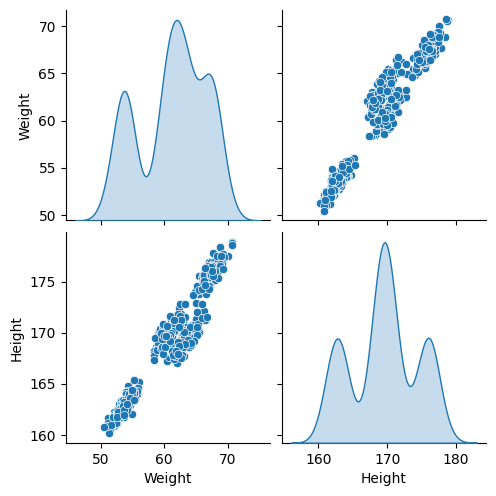

In [47]:
sns.pairplot(df, diag_kind='kde')
plt.show()

In [48]:
df.isnull().sum()

Weight    0
Height    0
dtype: int64

In [49]:
df.duplicated().sum()

0

In [50]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df = pd.DataFrame(df_scaled, columns=df.columns)

In [51]:
df.head()

,Weight,Height
0,1.115742,1.368788
1,1.451113,1.848408
2,-0.065368,0.160139
3,-0.295929,-0.171612
4,0.801458,0.884926


In [52]:
def gmm(X, n_clusters, n_iterations=100):
    
    tolerance = 1e-4  
    numerator_old = 0 
    Converged = 0 
    
    n_samples, n_features = X.shape
    means = X[np.random.choice(n_samples, n_clusters, replace=False)]
    covariances = [np.eye(n_features)] * n_clusters
    weights = np.ones(n_clusters) / n_clusters
  
    for iterations in range(n_iterations):
        # E-step
        responsibilities = []
     
        for k in range(n_clusters):
            numerator = multivariate_normal.pdf(X, mean=means[k], cov=covariances[k]) * weights[k]
            responsibilities.append(numerator)
        responsibilities = np.array(responsibilities).T
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        
        # M-step
        total_resp = np.sum(responsibilities, axis=0)
        weights = total_resp / n_samples
        means = (responsibilities.T @ X) / total_resp[:, np.newaxis]
        for k in range(n_clusters):
            diff = X - means[k]
            covariances[k] = ((responsibilities[:, k] * diff.T) @ diff) / total_resp[k]
            
 
        
        # stop condition 
        # Check if converged
        if np.linalg.norm(numerator - numerator_old) < tolerance:
            Converged = iterations
            break  
        
        numerator_old = numerator 

                
    return means, covariances, weights, Converged

In [53]:
# Assign samples to clusters
def assign_clusters(X, means, covariances, weights):
    n_samples = X.shape[0]
    n_clusters = len(means)
    responsibilities = np.zeros((n_samples, n_clusters))
    for k in range(n_clusters):
        responsibilities[:, k] = multivariate_normal.pdf(X, mean=means[k], cov=covariances[k]) * weights[k]
    cluster_assignments = np.argmax(responsibilities, axis=1)
    return cluster_assignments

In [54]:
# Fit GMM
n_clusters = 4
estimated_means, estimated_covariances, estimated_weights, Converged = gmm(df.values, n_clusters)

# Assign clusters
predicted_assignments = assign_clusters(df.values, estimated_means, estimated_covariances, estimated_weights)

Converged at iteration 35


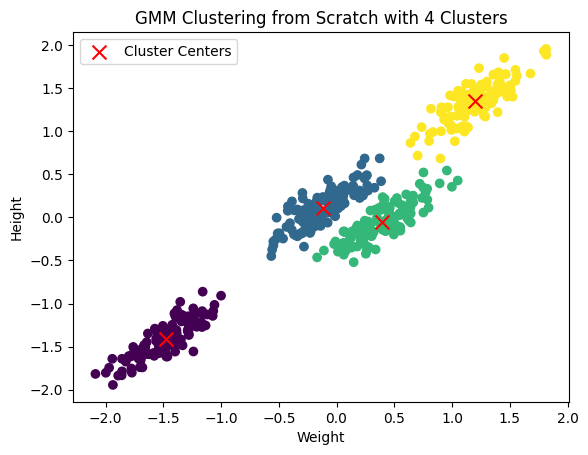

In [55]:
# Visualize the results
print(f"Converged at iteration {Converged}")
plt.scatter(df.values[:, 0], df.values[:, 1], c=predicted_assignments, cmap='viridis')
plt.scatter(estimated_means[:, 0], estimated_means[:, 1], marker='x', s=100, color='red', label='Cluster Centers')

plt.title(f'GMM Clustering from Scratch with {n_clusters} Clusters')
plt.xlabel('Weight')
plt.ylabel('Height')
plt.legend()
plt.show()

In [56]:
# Calculate silhouette score
GMM_silhouette_score = silhouette_score(df, predicted_assignments)
print(f"GMM Silhouette Score: {GMM_silhouette_score}")


GMM Silhouette Score: 0.600391282243889
